![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# **Taller No. 9 - ISIS4825**

## **Regresión Logística para Clasificación Binaria y Análisis de Componentes Principales**

## **Objetivos**

- Familiarizarse con la regresón logística y sus parámetros.
- Aplicar PCA como técnica de reducción de la dimensión.
- Pensar en un problema de categorías desbalanceadas.

## **Problema**
- En un dataset de imágenes de lenguaje de señas buscamos clasificar todas las imágenes que pertenezcan a la letra R de todas aquellas que pertenezcan a la letra E.


## **Notebook Configuration**

In [1]:
!shred -u setup_colab.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_9()


Extrayendo Zip File...
Eliminando Zip File...
Workshop 9 Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [2]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, ShuffleSplit, 
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             accuracy_score, f1_score, roc_curve, 
                             precision_recall_curve)
from sklearn.utils import resample

from utils import general as gen

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

## **Carga de Datos**

In [43]:
train_dir = gen.create_and_verify("data", "sign_mnist_train.csv")
test_dir = gen.create_and_verify("data", "sign_mnist_test.csv")

In [44]:
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [45]:
full_X_train, full_y_train = train_data.drop(columns=["label"]), train_data["label"]
X_test, y_test = test_data.drop(columns=["label"]), test_data["label"]

In [46]:
if (full_y_train == 9).sum() == 0 or (y_test == 9).sum() == 0:
    full_y_train = full_y_train.apply(lambda x: x - 1 if x > 8 else x)
    y_test = y_test.apply(lambda x: x - 1 if x > 8 else x)

In [67]:
if train_data.query("label==9").size == 0 or test_data.query("label==9").size == 0:
    train_data["label"] = train_data["label"].apply(lambda x: x - 1 if x > 8 else x)
    test_data["label"] = test_data["label"].apply(lambda x: x - 1 if x > 8 else x)

In [47]:
full_X_train.shape, full_y_train.shape

((27455, 784), (27455,))

In [37]:
X_test.shape, y_test.shape

((7172, 784), (7172,))

## **Visualización y Análisis Exploratorio**
- En este laboratorio vamos a usar una variación del dataset de MNIST pero que utiliza imágenes de lenguaje de señas. Cada número, desde el 0 hasta el 23, será asignado a cada seña. 

![image](https://docs.google.com/uc?export=download&id=17e0VoyKW_0HgmItDWqGiyB1Bl6C-e8G8)

- Este dataset consta de 7172 imágenes en total con clases madianamente balanceadas.

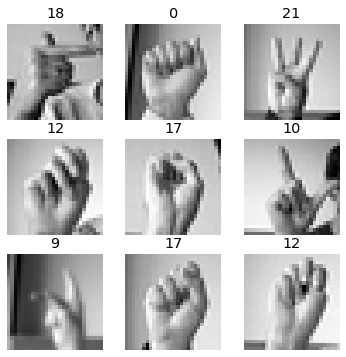

In [10]:
random_sample = full_X_train.sample(9, random_state=1234)
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    full_y_train[random_sample.index].values, (3, 3), (6, 6)
)

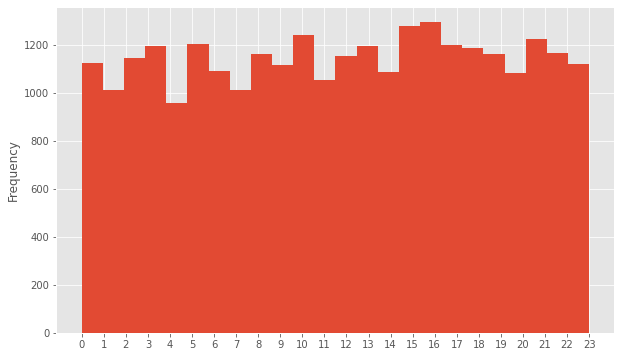

In [11]:
plt.figure(figsize=(10, 6))
ax = full_y_train.plot(kind="hist", bins=24)
ax.set_xticks(range(24))
plt.show()

In [12]:
full_y_train.value_counts().sort_index()

0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
9     1114
10    1241
11    1055
12    1151
13    1196
14    1088
15    1279
16    1294
17    1199
18    1186
19    1161
20    1082
21    1225
22    1164
23    1118
Name: label, dtype: int64

## **Preparación de los Datos**

In [13]:
random_sample = full_X_train.sample(1, random_state=5678)
sample_target = full_y_train[random_sample.index].values

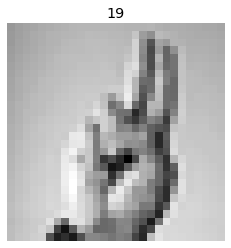

In [14]:
gen.imshow(random_sample.values.reshape(28, 28), color=False, 
           title=sample_target[0])

In [70]:
train_data_a = train_data.query("(label==4) | (label==16)")
test_data_a = test_data.query("(label==4) | (label==16)")

In [73]:
full_X_train, full_y_train = train_data_a.drop(columns=["label"]), train_data_a["label"]
X_test, y_test = test_data_a.drop(columns=["label"]), test_data_a["label"]

In [81]:
full_y_train = (full_y_train == 4).astype("uint8")
y_test = (y_test == 4).astype("uint8")

### **Train Set, Validation Set, Test Set**

In [83]:
X_train, X_val, y_train, y_val = train_test_split(full_X_train,
                                                  full_y_train,
                                                  test_size=0.2,
                                                  random_state=1234)

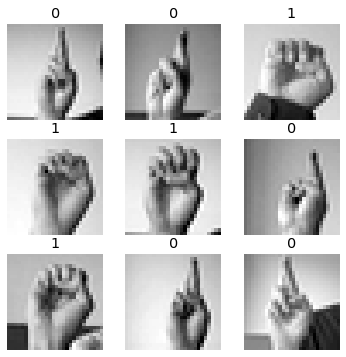

In [85]:
random_sample = X_train.sample(9, random_state=1234)
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    y_train[random_sample.index].values, (3, 3), (6, 6)
)

### **Desbalanceo de Clases**
- Algo muy usual dentro de los problemas de clasificación binaria es el desbalanceo de clases. Esto implica que nuestro algoritmo, probablemente, esté en capacidad de clasificar mejor una clase que otra, lo cual no debería ser.

$$\text{freq}_p = \frac{\text{Número de instancias positivas}}{\text{Total de instancias}}$$

$$\text{freq}_n = \frac{\text{Número de instancias negativas}}{\text{Total de instancias}}$$

- En este caso, vamos a usar un método de la librería `Scikit-Learn` llamado `resample`. Esta función nos va a permitir hacer un remuestreo de la clase con mayor cantidad de instancias para que tenga igual número de muestras que la clase con menor cantidad de instancias.

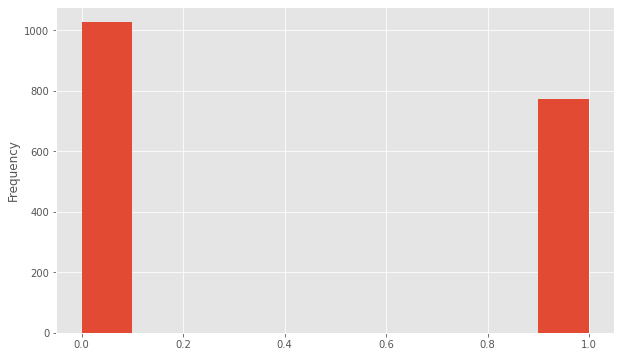

In [86]:
plt.figure(figsize=(10, 6))
y_train.astype("int").plot(kind="hist")
plt.show()

In [87]:
def cat_frequencies(labels):
    freq_p = labels.mean()
    freq_n = 1 - freq_p
    return freq_p, freq_n

In [88]:
f_p, f_n = cat_frequencies(y_train)

In [89]:
f_p, f_n

(0.42944444444444446, 0.5705555555555555)

In [90]:
total = pd.concat([X_train, y_train], axis=1)

In [91]:
neg_class = total.query("label==0")
pos_class = total.query("label==1")

In [92]:
neg_class_downsampled = resample(neg_class, replace=False,
                                 n_samples=len(pos_class), 
                                 random_state=1234)

In [93]:
balanced_data = pd.concat([neg_class_downsampled, pos_class])

In [94]:
y_train = balanced_data["label"]
X_train = balanced_data.drop("label", axis=1)

In [96]:
f_p, f_n = cat_frequencies(y_train)

In [97]:
f_p, f_n

(0.5, 0.5)

## **Modelamiento**
- En esta ocasión se hará uso de la regresión Logística, una función lineal ampliamente usada en problemas de clasificación binaria.

In [102]:
log_reg = LogisticRegression(n_jobs=-1)

In [103]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## **Predicción**

In [104]:
random_sample = X_test.sample(9, random_state=1234)
y_pred = log_reg.predict(random_sample)

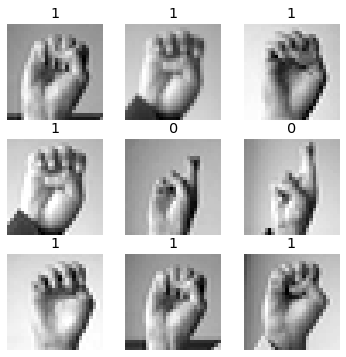

In [106]:
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)

## **Validación**

In [107]:
y_pred = log_reg.predict(X_test)

In [108]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [109]:
pd.DataFrame(conf_matrix)

,0,1
0,144,0
1,0,498


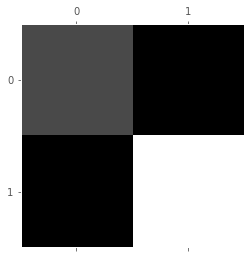

In [110]:
plt.matshow(conf_matrix, cmap="gray")
plt.grid(0)
plt.show()

In [111]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

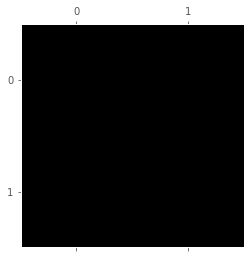

In [112]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.grid(0)
plt.show()

In [113]:
accuracy_score(y_test, y_pred)

1.0

In [114]:
recall_score(y_test, y_pred)

1.0

In [115]:
precision_score(y_test, y_pred)

1.0